# Performing PCA with an Undercomplete Linear Autoencoder

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder,decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)
autoencoder.compile(loss="mse",optimizer = optimizer)

In [28]:
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]

In [29]:
history = autoencoder.fit(X_train,X_train,epochs=500,verbose=False)
codings = autoencoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step


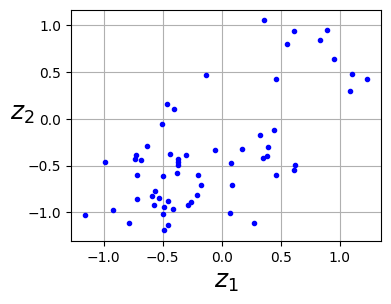

In [30]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

# Stacked Autoencoders

In [31]:

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [32]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(20,activation="relu")
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28,28])
])

stacked_autoencoder = tf.keras.Sequential([stacked_encoder,stacked_decoder])
stacked_autoencoder.compile(loss="mse",optimizer=tf.keras.optimizers.Nadam())

history = stacked_autoencoder.fit(X_train,X_train,
                                  epochs = 30,
                                  validation_data=(X_valid,X_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0358 - val_loss: 0.0192
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0186 - val_loss: 0.0180
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0176 - val_loss: 0.0173
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0164 - val_loss: 0.0165
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0162 - val_loss: 0.0162
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 9/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 10/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 11/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0154 - val_loss: 0.0155
Epoch 12/30
1719/1719 ━━━━━━

In [40]:
def plot_reconstructions(model,images=X_valid,n_images=5):
  plt.figure(figsize=(5,2))
  reconstructions = np.clip(model.predict(images[:n_images]),0,1)
  for image_index in range(n_images):
    plt.subplot(2,n_images,image_index+1)
    plt.imshow(images[image_index],cmap="binary")
    plt.axis("off")
    plt.subplot(2,n_images,1+image_index+n_images)
    plt.imshow(reconstructions[image_index],cmap="binary")
    plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


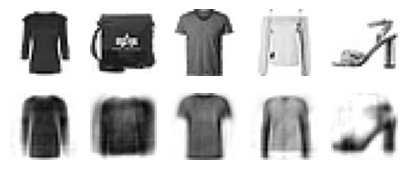

In [41]:

plot_reconstructions(stacked_autoencoder)
plt.show()

## Visualizing the Dataset

In [35]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne= TSNE(init="pca",learning_rate="auto")
X_valid_2D = tsne.fit_transform(X_valid_compressed)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(np.float64(-0.045314037799835206),
 np.float64(0.9515947937965393),
 np.float64(0.007713497057557105),
 np.float64(1.0472517382353543))

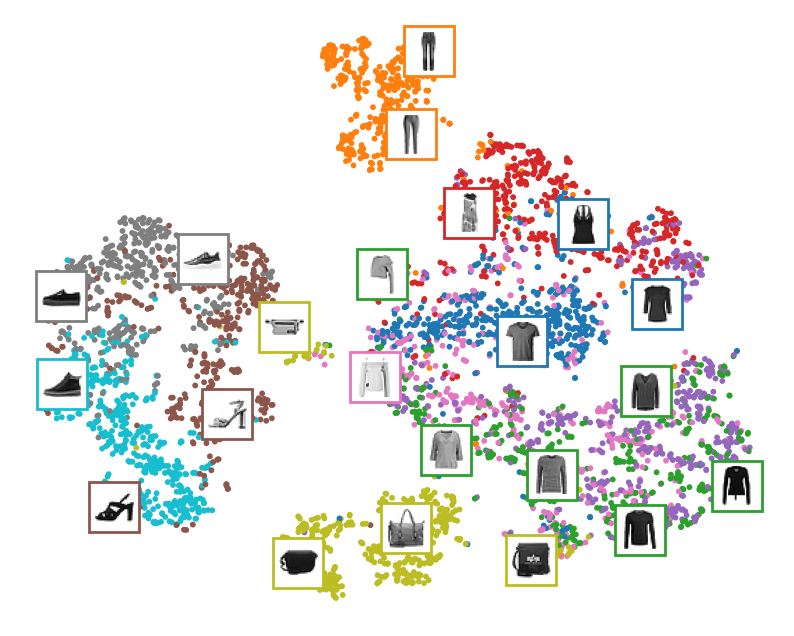

In [36]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")

# Convolutional Autoencoders

In [39]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28,28,1]),
    tf.keras.layers.Conv2D(16,3,padding="same",activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32,3,padding="same",activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(64,3,padding="same",activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(30,3,padding="same",activation="relu"),
    tf.keras.layers.GlobalAveragePooling2D()
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3*3*16),
    tf.keras.layers.Reshape((3,3,16)),
    tf.keras.layers.Conv2DTranspose(32,3,strides=2,activation="relu"),
    tf.keras.layers.Conv2DTranspose(16,3,strides=2,padding="same",activation="relu"),
tf.keras.layers.Conv2DTranspose(1,3,strides=2,padding="same"),
    tf.keras.layers.Reshape([28,28])

])
conv_autoencoder = tf.keras.Sequential([conv_encoder,conv_decoder])
conv_autoencoder.compile(loss="mse",optimizer=tf.keras.optimizers.Nadam())
history = conv_autoencoder.fit(X_train,X_train,epochs=10,
                               validation_data=(X_valid,X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0462 - val_loss: 0.0202
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0191 - val_loss: 0.0174
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0168 - val_loss: 0.0161
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0135 - val_loss: 0.0147
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0124 - val_loss: 0.0122


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


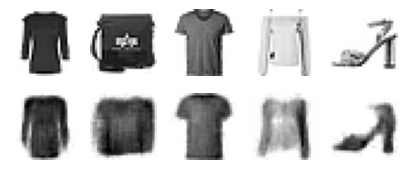

In [43]:
plot_reconstructions(conv_autoencoder)


## Denoising Autoencoders

In [44]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(30,activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])
dropout_autoencoder = tf.keras.Sequential([dropout_encoder,dropout_decoder])
dropout_autoencoder.compile(loss="mse",optimizer=tf.keras.optimizers.Nadam())
history = dropout_autoencoder.fit(X_train,X_train,
                                  epochs=10,
                                  validation_data=(X_valid,X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0399 - val_loss: 0.0216
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0225 - val_loss: 0.0199
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0213 - val_loss: 0.0190
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0204 - val_loss: 0.0183
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0198 - val_loss: 0.0178
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0194 - val_loss: 0.0176
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0191 - val_loss: 0.0172
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0188 - val_loss: 0.0170
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0186 - val_loss: 0.0168
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0184 - val_loss: 0.0166


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


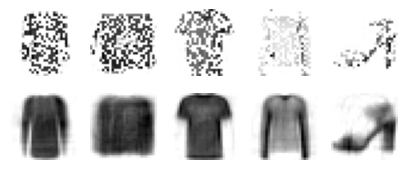

In [45]:
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_autoencoder,dropout(X_valid,training=True))
plt.show()
